## Binary Classification Problem with Target values either 0 or 1

COnnect to google drive for dataset reading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import libraries for importing data, visualization and EDA

In [ ]:
import pandas as pd, numpy as np, time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

# to impute the missing values
from sklearn.impute import SimpleImputer

from scipy import stats
from scipy.stats import norm, skew

Set the path path of the data set, which will be referred down the line to access the train/test data.

Also same path will use to store the submission file at the ned of the mdoel run

In [ ]:
dataSetPath = '/content/gdrive/My Drive/Colab Notebooks/KaggleDatasets/NovartisDataSet'

Read train and test data into the dataframe

In [ ]:
dfTrain = pd.read_csv(dataSetPath + '/NovartisMaliciousTrain.csv')
dfTest = pd.read_csv(dataSetPath + '/NovartisMaliciousTest.csv')

In next 4 lines will see the shape and first 5 rows of the train and test data sets

In [ ]:
dfTrain.shape

(23856, 18)

In [ ]:
dfTest.shape

(15903, 17)

In [ ]:
dfTrain.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [ ]:
dfTest.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


Info on dataframe will help us know the number of rows, columns and the data types of each column

In [ ]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   INCIDENT_ID       23856 non-null  object 
 1   DATE              23856 non-null  object 
 2   X_1               23856 non-null  int64  
 3   X_2               23856 non-null  int64  
 4   X_3               23856 non-null  int64  
 5   X_4               23856 non-null  int64  
 6   X_5               23856 non-null  int64  
 7   X_6               23856 non-null  int64  
 8   X_7               23856 non-null  int64  
 9   X_8               23856 non-null  int64  
 10  X_9               23856 non-null  int64  
 11  X_10              23856 non-null  int64  
 12  X_11              23856 non-null  int64  
 13  X_12              23674 non-null  float64
 14  X_13              23856 non-null  int64  
 15  X_14              23856 non-null  int64  
 16  X_15              23856 non-null  int64 

Check if any columns is having null values, if yes then we will have to impute them based on different strategies

In [ ]:
dfTrain.isnull().any()

INCIDENT_ID         False
DATE                False
X_1                 False
X_2                 False
X_3                 False
X_4                 False
X_5                 False
X_6                 False
X_7                 False
X_8                 False
X_9                 False
X_10                False
X_11                False
X_12                 True
X_13                False
X_14                False
X_15                False
MULTIPLE_OFFENSE    False
dtype: bool

We can see that column X-12 has null values, rest all columns seems have all data

In [ ]:
dfTrain.describe().T

,count,mean,std,min,25%,50%,75%,max
X_1,23856.0,0.483778,1.439738,0.0,0.0,0.0,0.0,7.0
X_2,23856.0,24.791206,15.240231,0.0,7.0,24.0,36.0,52.0
X_3,23856.0,24.637450,15.135093,0.0,8.0,24.0,35.0,52.0
X_4,23856.0,4.276744,2.944672,0.0,2.0,4.0,6.0,10.0
X_5,23856.0,2.455609,1.963095,0.0,1.0,3.0,5.0,5.0
X_6,23856.0,6.154175,4.471756,1.0,3.0,5.0,8.0,19.0
X_7,23856.0,4.876509,3.881931,0.0,2.0,4.0,7.0,18.0
X_8,23856.0,0.972460,1.453144,0.0,0.0,1.0,1.0,99.0
X_9,23856.0,4.924128,1.362625,0.0,5.0,5.0,6.0,6.0
X_10,23856.0,1.244802,1.119301,1.0,1.0,1.0,1.0,90.0


Let's first get rid of the NaN values in the column X_12

We can see the value 1.0 is highest in count, and also the data is skewed a lot, with max being 90 whereas the median is 1.0
So to fill missing values let's use mode() to achieve it

In [ ]:
# create a copy of datasets

dfNonBlankTrain = dfTrain.copy()
dfNonBlankTest = dfTest.copy()

Based on the data present in the X-12 column high % of data belongs to "1"

So imputing the missing value with MODE

In [ ]:
# X_12 column
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dfNonBlankTrain['X_12'] = imputer.fit_transform(dfNonBlankTrain[['X_12']])
dfNonBlankTest['X_12'] = imputer.fit_transform(dfNonBlankTest[['X_12']])

In [ ]:
dfNonBlankTrain.isnull().sum()

INCIDENT_ID         0
DATE                0
X_1                 0
X_2                 0
X_3                 0
X_4                 0
X_5                 0
X_6                 0
X_7                 0
X_8                 0
X_9                 0
X_10                0
X_11                0
X_12                0
X_13                0
X_14                0
X_15                0
MULTIPLE_OFFENSE    0
dtype: int64

In [ ]:
dfNonBlankTest.isnull().sum()

INCIDENT_ID    0
DATE           0
X_1            0
X_2            0
X_3            0
X_4            0
X_5            0
X_6            0
X_7            0
X_8            0
X_9            0
X_10           0
X_11           0
X_12           0
X_13           0
X_14           0
X_15           0
dtype: int64

The 'Date' Column:

Data Cleaning & Feature Engineering:

In [ ]:
# check for missing value
dfNonBlankTrain.DATE.isnull().any(), dfNonBlankTest.DATE.isnull().any()

(False, False)

In [ ]:
dfNonBlankTrain['DATE'] = pd.to_datetime(dfNonBlankTrain['DATE'])
dfNonBlankTest['DATE'] = pd.to_datetime(dfNonBlankTest['DATE'])

In [ ]:
dfNonBlankTrain['DATE'] = pd.to_datetime(dfNonBlankTrain['DATE'], format='%Y-%m-%d')
dfNonBlankTest['DATE'] = pd.to_datetime(dfNonBlankTest['DATE'], format='%Y-%m-%d')


In [ ]:
dfNonBlankTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   INCIDENT_ID       23856 non-null  object        
 1   DATE              23856 non-null  datetime64[ns]
 2   X_1               23856 non-null  int64         
 3   X_2               23856 non-null  int64         
 4   X_3               23856 non-null  int64         
 5   X_4               23856 non-null  int64         
 6   X_5               23856 non-null  int64         
 7   X_6               23856 non-null  int64         
 8   X_7               23856 non-null  int64         
 9   X_8               23856 non-null  int64         
 10  X_9               23856 non-null  int64         
 11  X_10              23856 non-null  int64         
 12  X_11              23856 non-null  int64         
 13  X_12              23856 non-null  float64       
 14  X_13              2385

In [ ]:
dfNonBlankTrain.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


Create separate columns for 'Year', 'Month', 'Day'

In [ ]:
dfNonBlankTrain['Year'] = dfNonBlankTrain.DATE.dt.year
dfNonBlankTrain['Year'].sample(3)

19187    2006
17888    1997
15102    2015
Name: Year, dtype: int64

In [ ]:
dfNonBlankTest['Year'] = dfNonBlankTest.DATE.dt.year
dfNonBlankTest['Year'].sample(3)

3331     2017
14459    1997
799      1997
Name: Year, dtype: int64

In [ ]:
dfNonBlankTrain['Month'] = dfNonBlankTrain.DATE.dt.month
dfNonBlankTrain['Month'].sample(3)

6783      5
16098    10
13007     1
Name: Month, dtype: int64

In [ ]:
dfNonBlankTest['Month'] = dfNonBlankTest.DATE.dt.month
dfNonBlankTest['Month'].sample(3)

880      6
15560    6
13561    2
Name: Month, dtype: int64

In [ ]:
dfNonBlankTrain['Day'] = dfNonBlankTrain.DATE.dt.day
dfNonBlankTrain['Day'].sample(3)

11486    17
7937     31
13922    22
Name: Day, dtype: int64

In [ ]:
dfNonBlankTest['Day'] = dfNonBlankTest.DATE.dt.day
dfNonBlankTest['Day'].sample(3)

15726    25
6372     28
202      19
Name: Day, dtype: int64

In [ ]:
dfNonBlankTrain.DATE.dt.dayofweek.head()

0    6
1    1
2    2
3    4
4    2
Name: DATE, dtype: int64

In [ ]:
dfNonBlankTrain['DayOfWeek'] = dfNonBlankTrain.DATE.dt.dayofweek
dfNonBlankTrain['DayOfWeek'].sample(3)

4788     6
21962    3
6802     4
Name: DayOfWeek, dtype: int64

In [ ]:
dfNonBlankTest['DayOfWeek'] = dfNonBlankTest.DATE.dt.dayofweek
dfNonBlankTest['DayOfWeek'].sample(3)

2752    3
9802    2
5663    3
Name: DayOfWeek, dtype: int64

In [ ]:
# dfNonBlankTest.drop('DayOfWeekInt', axis=1, inplace=True)

In [ ]:
dfNonBlankTrain.sample(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Year,Month,Day,DayOfWeek
10035,CR_175823,2015-08-10,0,33,32,2,1,8,3,0,5,1,174,0.0,92,93,43,1,2015,8,10,0
17271,CR_194436,2018-03-13,0,21,23,4,1,2,7,2,6,2,43,1.0,109,6,34,0,2018,3,13,1
11661,CR_144301,2010-08-27,1,22,22,7,3,15,10,0,5,1,174,1.0,54,130,34,1,2010,8,27,4


In [ ]:
dfNonBlankTest.sample(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month,Day,DayOfWeek
3275,CR_189064,2017-07-29,0,33,32,2,1,8,3,1,6,1,249,1.0,102,29,34,2017,7,29,5
1559,CR_142578,2010-05-09,1,4,4,6,5,15,10,2,6,1,249,1.0,72,29,34,2010,5,9,6
15564,CR_81648,2001-11-14,0,47,48,7,3,4,2,1,5,1,316,0.0,103,142,34,2001,11,14,2


In [ ]:
dfNonBlankTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   INCIDENT_ID       23856 non-null  object        
 1   DATE              23856 non-null  datetime64[ns]
 2   X_1               23856 non-null  int64         
 3   X_2               23856 non-null  int64         
 4   X_3               23856 non-null  int64         
 5   X_4               23856 non-null  int64         
 6   X_5               23856 non-null  int64         
 7   X_6               23856 non-null  int64         
 8   X_7               23856 non-null  int64         
 9   X_8               23856 non-null  int64         
 10  X_9               23856 non-null  int64         
 11  X_10              23856 non-null  int64         
 12  X_11              23856 non-null  int64         
 13  X_12              23856 non-null  float64       
 14  X_13              2385

Let's Check the range of Dates:

In [ ]:
dfNonBlankTrain.DATE.min(), dfNonBlankTrain.DATE.max()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

Malaciuos Attacks per Year visualization

In [ ]:
malaciousYear = dfNonBlankTrain.groupby('Year')['MULTIPLE_OFFENSE'].count()
malaciousYear

Year
1991     512
1992     792
1993     962
1994     724
1995     838
1996    1040
1997     952
1998     947
1999     865
2000    1016
2001    1186
2002     844
2003     890
2004     897
2005     873
2006     989
2007     903
2008     941
2009     776
2010     783
2011     759
2012     823
2013     703
2014     678
2015     720
2016     743
2017     884
2018     816
Name: MULTIPLE_OFFENSE, dtype: int64

Text(0, 0.5, 'Count of MULTIPLE_OFFENSE')

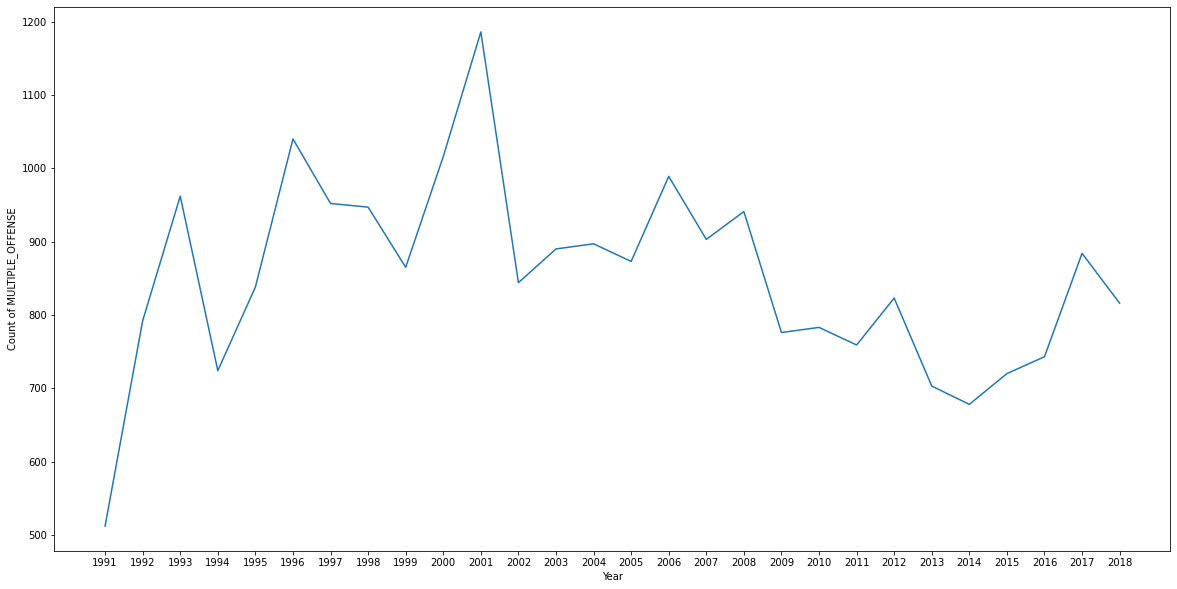

In [ ]:
plt.figure(figsize=(20, 10))
ax = malaciousYear.plot(kind='line', xticks=malaciousYear.index.values)
ax.set_ylabel('Count of MULTIPLE_OFFENSE')

Malaciuos Attacks per Day Of Week visualization

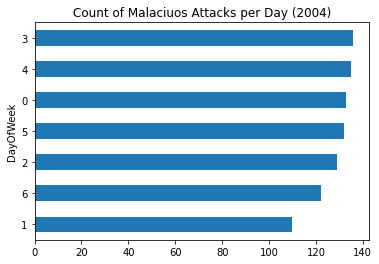

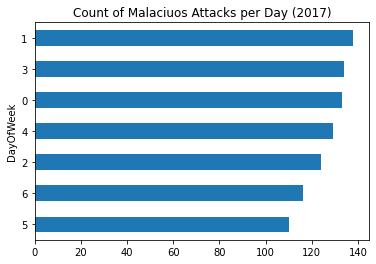

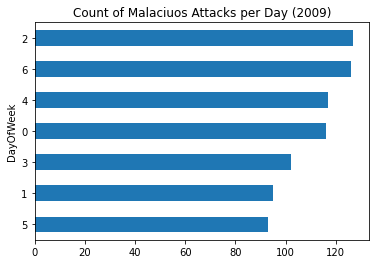

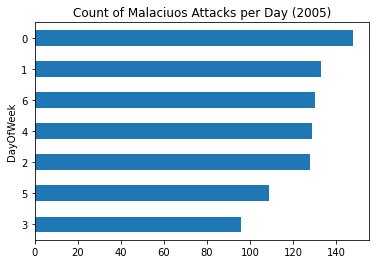

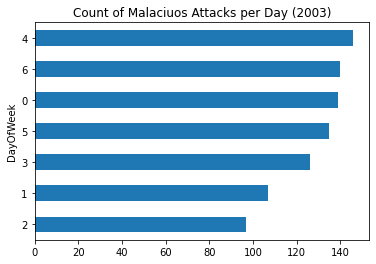

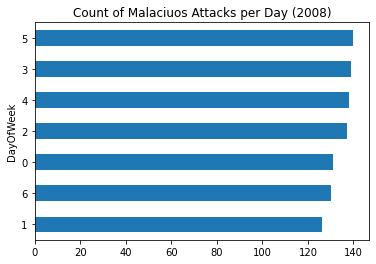

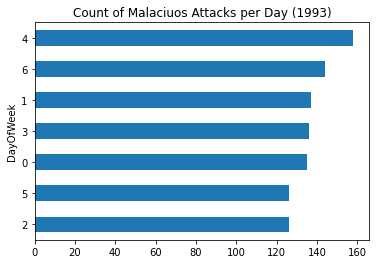

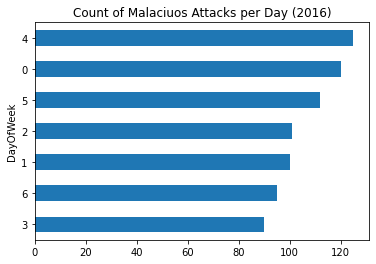

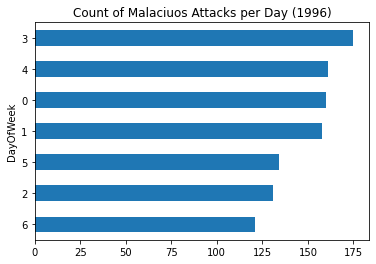

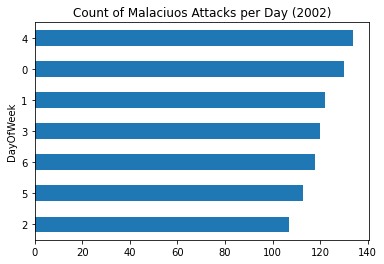

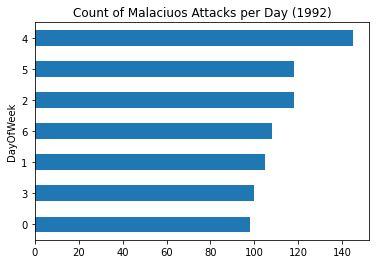

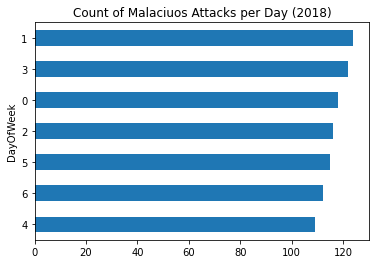

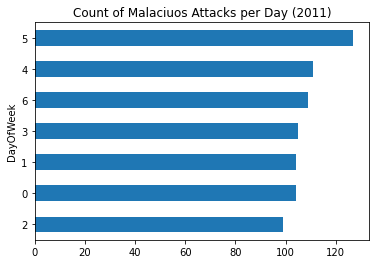

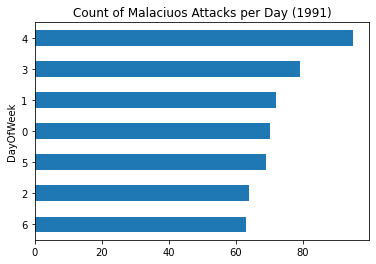

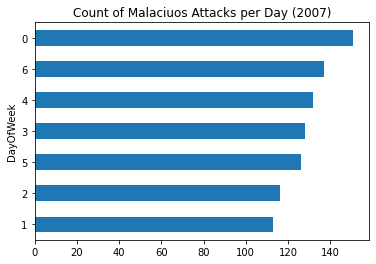

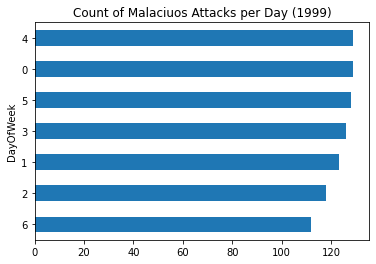

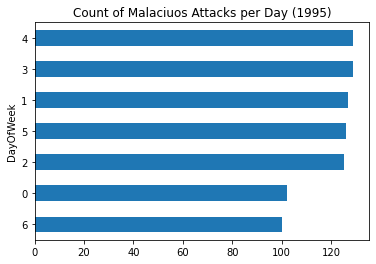

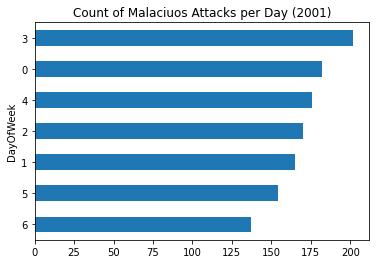

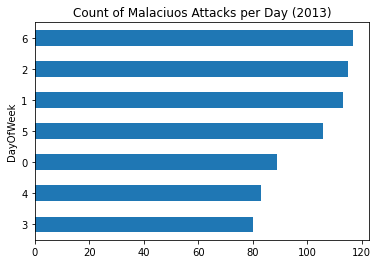

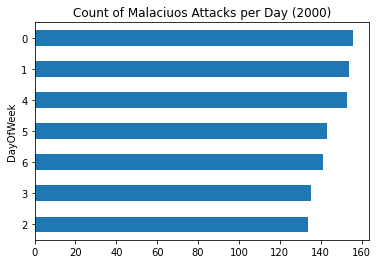

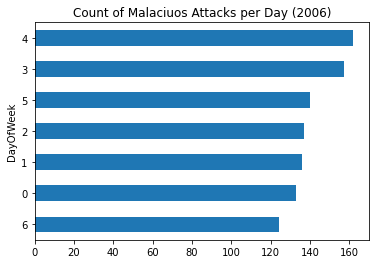

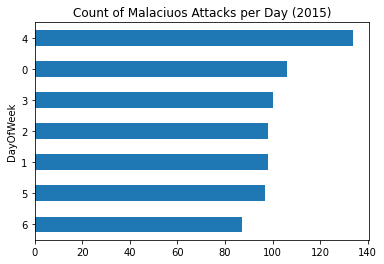

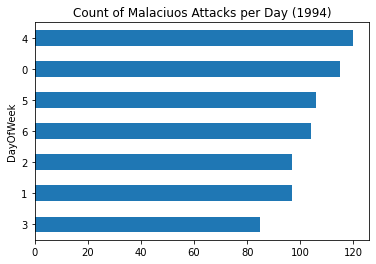

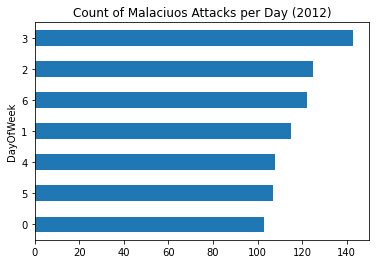

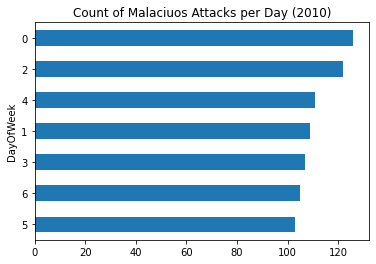

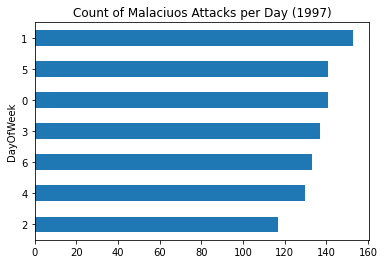

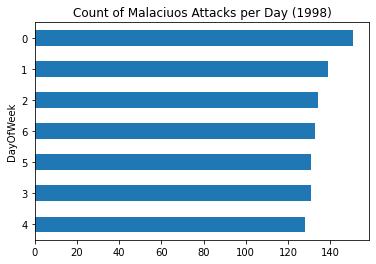

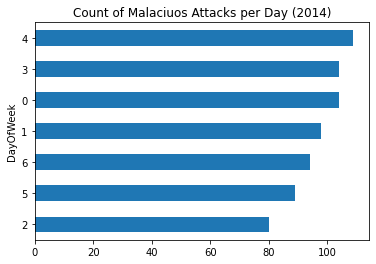

In [ ]:
for y in dfNonBlankTrain.Year.unique():
    dfNonBlankTrain[dfNonBlankTrain['Year'] == y].groupby('DayOfWeek')['MULTIPLE_OFFENSE'].count().sort_values().plot(kind='barh', 
                                                                                                              title=f'Count of Malaciuos Attacks per Day ({y})', 
                                                                                                              fig=(16,5))
    plt.show()

Malaciuos Attacks per Month visualization

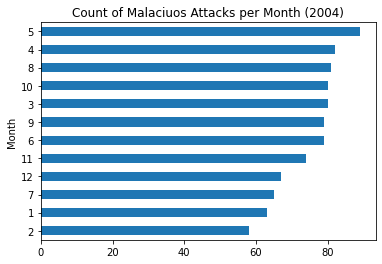

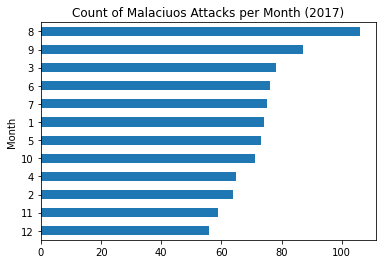

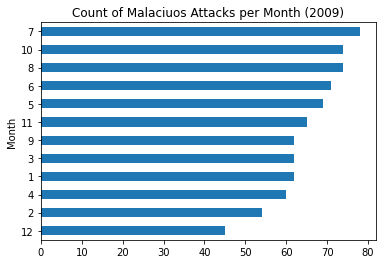

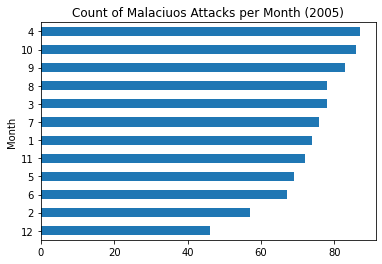

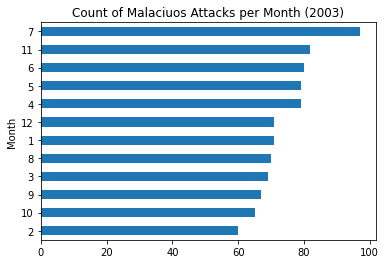

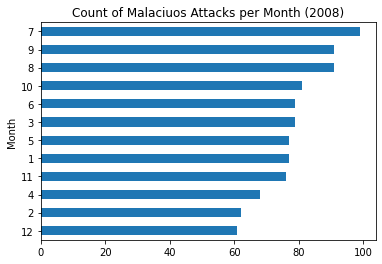

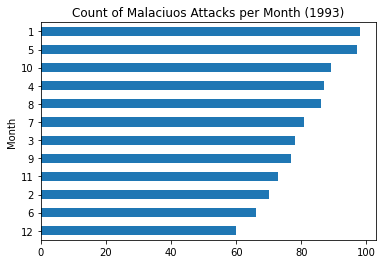

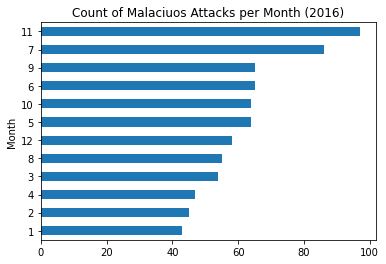

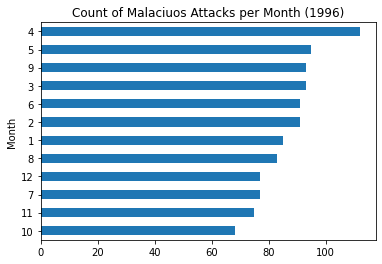

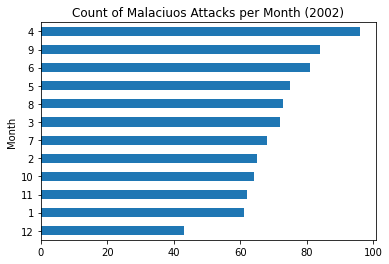

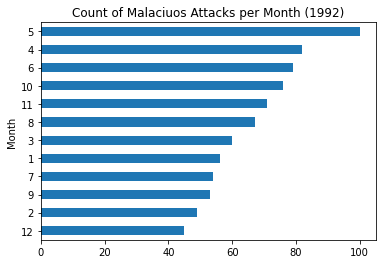

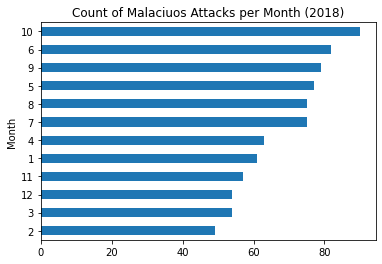

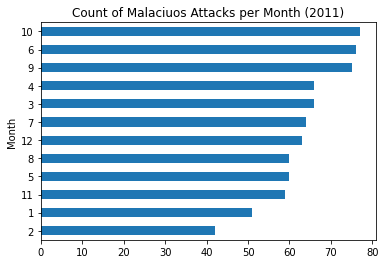

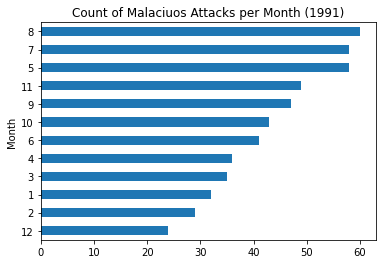

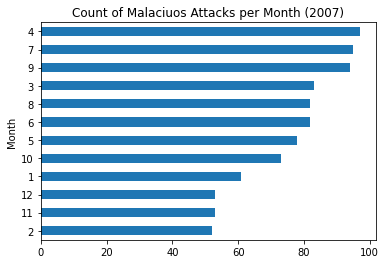

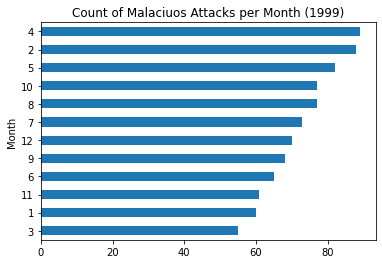

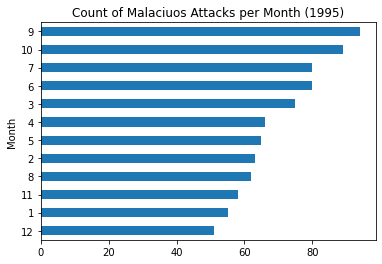

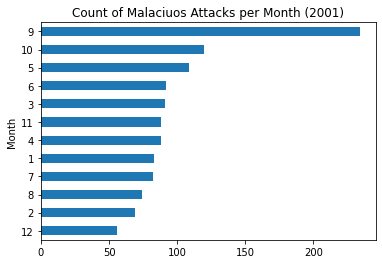

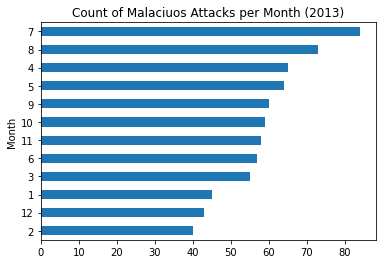

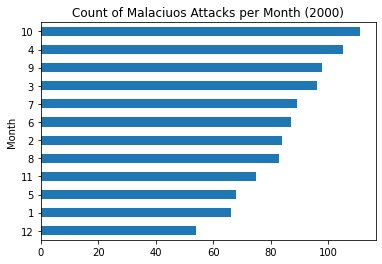

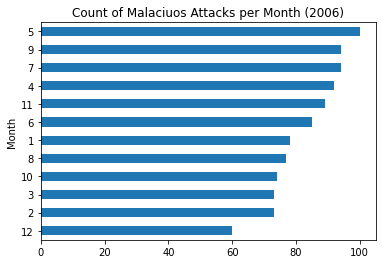

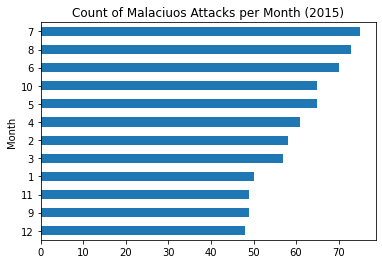

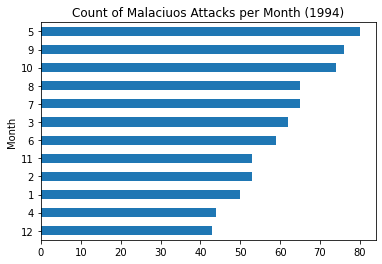

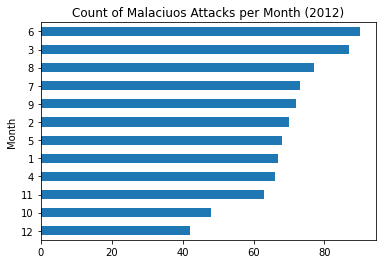

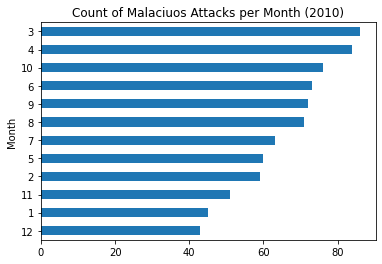

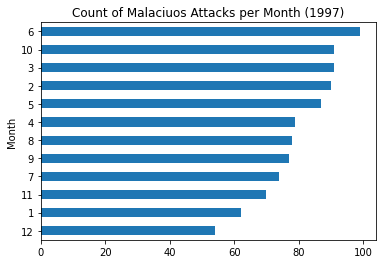

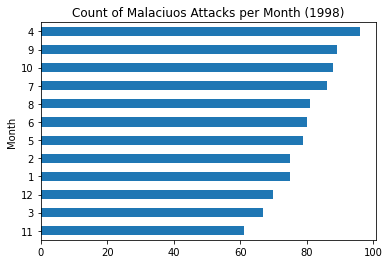

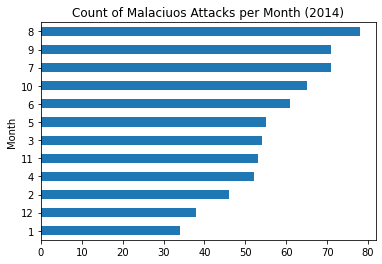

In [ ]:
for y in dfNonBlankTrain.Year.unique():
    dfNonBlankTrain[dfNonBlankTrain['Year'] == y].groupby('Month')['MULTIPLE_OFFENSE'].count().sort_values().plot(kind='barh', 
                                                                                                          title=f'Count of Malaciuos Attacks per Month ({y})', 
                                                                                                          fig=(16,5))
    plt.show()

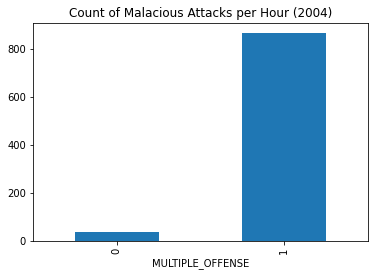

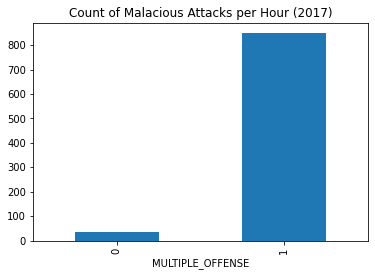

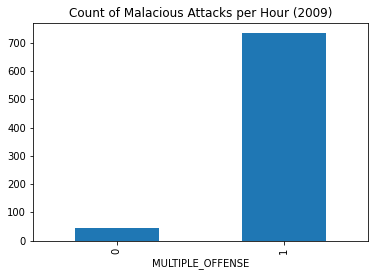

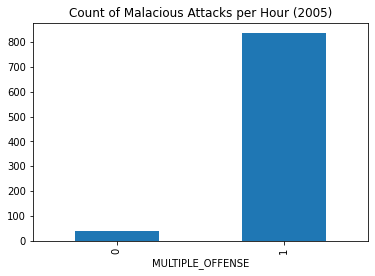

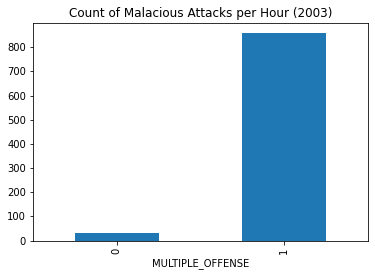

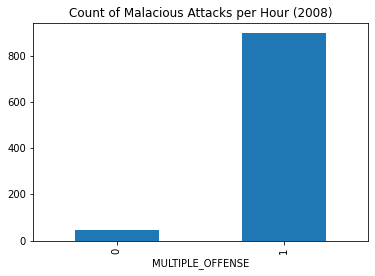

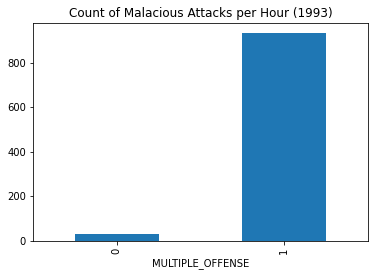

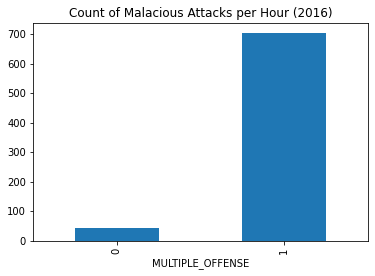

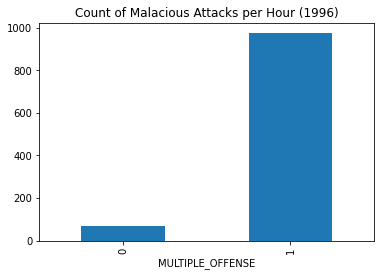

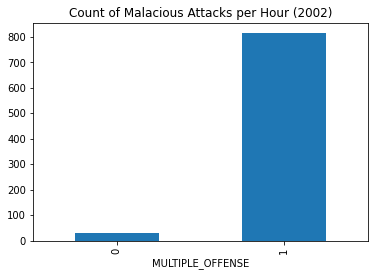

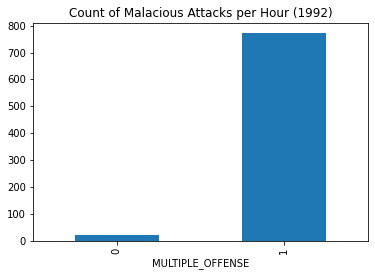

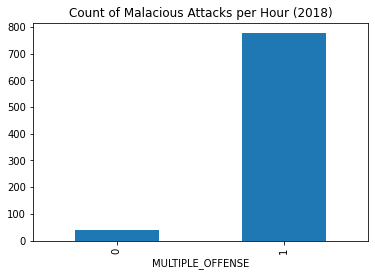

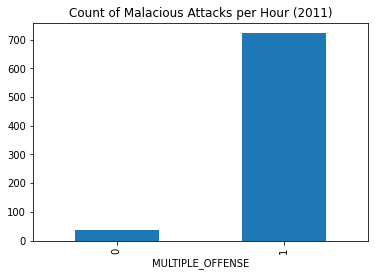

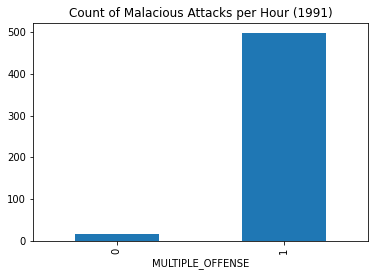

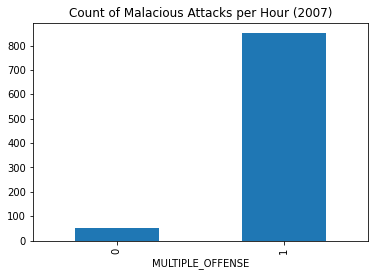

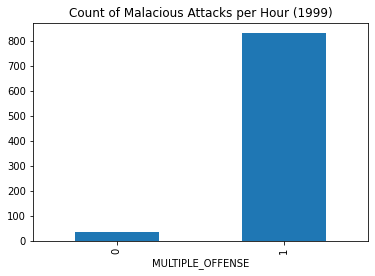

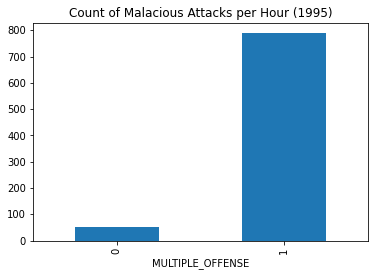

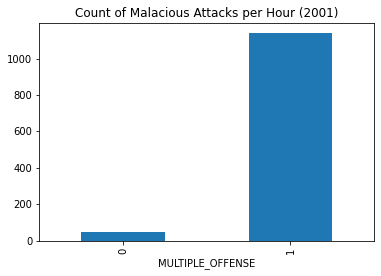

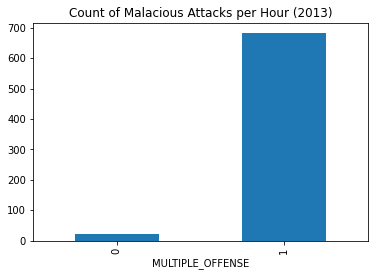

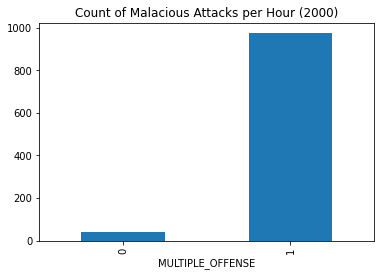

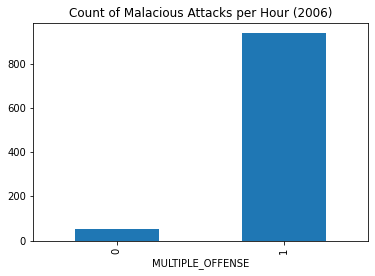

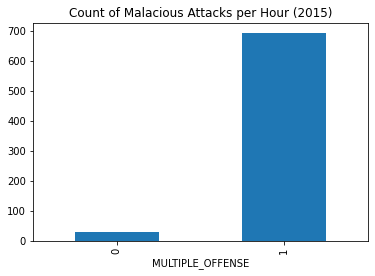

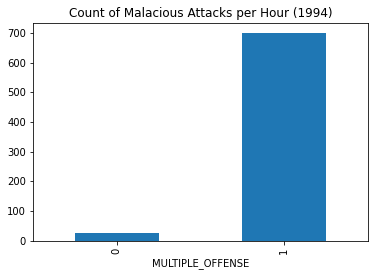

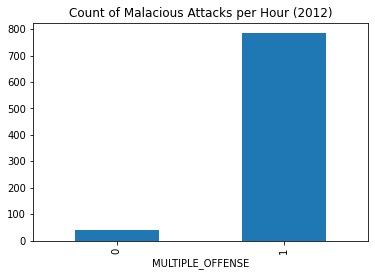

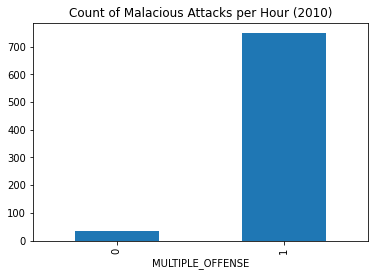

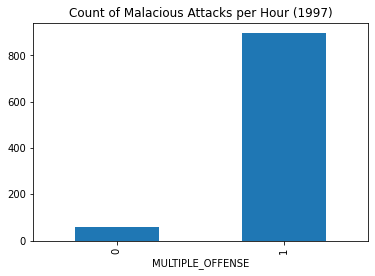

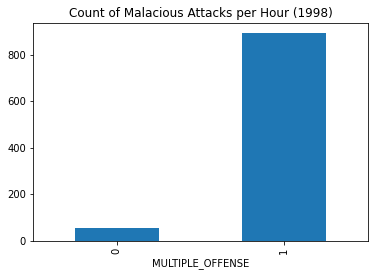

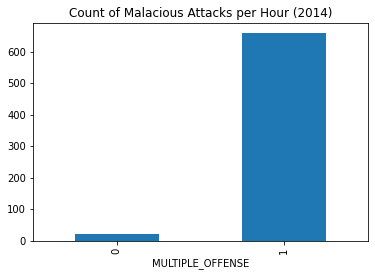

In [ ]:
for y in dfNonBlankTrain.Year.unique():
    ax = dfNonBlankTrain[dfNonBlankTrain['Year'] == y].groupby('MULTIPLE_OFFENSE')['Year'].count().sort_values().plot(kind='bar', 
                                                                                                                      title=f'Count of Malacious Attacks per Hour ({y})', 
                                                                                                                      fig=(18,7))
    plt.show()

In [ ]:
# # set path first then save the cleaned dataset files
# dfNonBlankTrain.to_csv('dfNonBlankTrain_Clean_1.csv',index=False)
# dfNonBlankTest.to_csv('dfNonBlankTest_Clean_1.csv',index=False)
# print('Done Outputing')

### About the Target Column

In [ ]:
# Let us look at the target column which is 'Target' to understand how the data is distributed amongst the various classes
dfNonBlankTrain.groupby(["MULTIPLE_OFFENSE"])["MULTIPLE_OFFENSE"].count()

MULTIPLE_OFFENSE
0     1068
1    22788
Name: MULTIPLE_OFFENSE, dtype: int64

Highly unbalanced data

To make it easy to understand if a classifier were to train with this data set trying to achieve the best accuracy possible it would most likely label every transaction as a YES Target

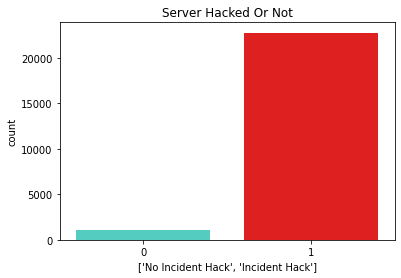

In [ ]:
# Check Target variables that has 0 value for No Incident Hack and 1 for Incident Hack
sns.countplot('MULTIPLE_OFFENSE',data=dfNonBlankTrain,palette=['turquoise','r'])
plt.title('Server Hacked Or Not')
plt.xlabel(['No Incident Hack', 'Incident Hack'], fontsize=10)
plt.show()

In [ ]:
trainDf = dfNonBlankTrain.copy()
testDf = dfNonBlankTest.copy()

Feature Selection 

In [ ]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   INCIDENT_ID       23856 non-null  object        
 1   DATE              23856 non-null  datetime64[ns]
 2   X_1               23856 non-null  int64         
 3   X_2               23856 non-null  int64         
 4   X_3               23856 non-null  int64         
 5   X_4               23856 non-null  int64         
 6   X_5               23856 non-null  int64         
 7   X_6               23856 non-null  int64         
 8   X_7               23856 non-null  int64         
 9   X_8               23856 non-null  int64         
 10  X_9               23856 non-null  int64         
 11  X_10              23856 non-null  int64         
 12  X_11              23856 non-null  int64         
 13  X_12              23856 non-null  float64       
 14  X_13              2385

In [ ]:
trainDf.columns

Index(['INCIDENT_ID', 'DATE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15',
       'MULTIPLE_OFFENSE', 'Year', 'Month', 'Day', 'DayOfWeek'],
      dtype='object')

In [ ]:
len(trainDf.INCIDENT_ID.unique())

23856

In [ ]:
testDf.columns

Index(['INCIDENT_ID', 'DATE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'Year',
       'Month', 'Day', 'DayOfWeek'],
      dtype='object')

In [ ]:
feature_cols = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
                'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15',
                'Year', 'Month', 'Day', 'DayOfWeek']

target_col = 'MULTIPLE_OFFENSE'

train_x = trainDf[feature_cols]
train_y = trainDf[target_col]

test_ids = testDf['INCIDENT_ID']
test_x = testDf[feature_cols]

In [ ]:
train_x.sample(2)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month,Day,DayOfWeek
18077,0,21,23,4,1,5,6,0,5,1,249,1.0,112,93,34,2003,3,18,1
12807,0,4,4,6,5,1,0,1,6,1,316,1.0,103,130,34,1996,7,1,0


In [ ]:
test_x.sample(2)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month,Day,DayOfWeek
10899,0,45,45,10,3,3,5,1,6,2,0,2.0,103,29,34,1996,3,24,6
932,0,16,15,0,0,6,4,1,2,1,316,1.0,98,142,34,1999,6,7,0


Import libraries for the model training, fine tuning and scores

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, KFold
import sklearn.metrics as sklm
from math import sqrt
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Let's Create some functions


In [ ]:
def print_scores(y_test,y_pred,y_pred_prob):
    print("Accuracy score: \n", accuracy_score(y_test,y_pred))
    print('Test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("Classification report:" "\n", classification_report(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

In [ ]:
# drawing roc curve
def roc_curve_draw(fpr, tpr, thr):
    # drawing roc curve
    idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensitivity > 0.95
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [ ]:
# model fitting
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('Train-set confusion matrix:\n', confusion_matrix(y_train,train_pred))
    return y_pred, y_pred_prob

Split the data into train test

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(train_x, train_y, test_size=0.3, random_state=22)

Highly imbalanced data as we have see above in the analysis of the target column using bar chart.

This will require some sampling and balancing of data, as in above Confusion Matrix, the maximum data fell into the "1" value

In [ ]:
notHacked = trainDf[trainDf.MULTIPLE_OFFENSE == 0]['MULTIPLE_OFFENSE'].count()

In [ ]:
hacked = trainDf[trainDf.MULTIPLE_OFFENSE == 1]['MULTIPLE_OFFENSE'].count()

In [ ]:
scale_pos_weight = sqrt(hacked/notHacked) 
scale_pos_weight

4.619207578328278

In [ ]:
model = XGBClassifier(max_depth=3, n_estimators=500, n_jobs=-1, scale_pos_weight=scale_pos_weight)
# model.fit(X_train, y_train)

In [ ]:
y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)

Train-set confusion matrix:
 [[  749     1]
 [    0 15949]]


============================== Model Evaluation ==============================
Accuracy score: 
 0.9990219365656001
Test-set confusion matrix:
 [[ 311    7]
 [   0 6839]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       318
           1       1.00      1.00      1.00      6839

    accuracy                           1.00      7157
   macro avg       1.00      0.99      0.99      7157
weighted avg       1.00      1.00      1.00      7157

ROC AUC: 1.0


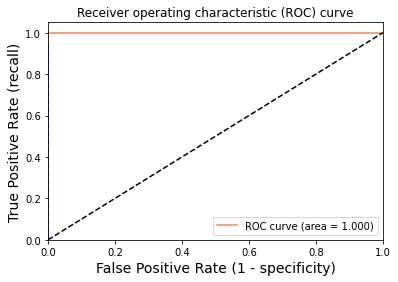

Using a threshold of 1.000 guarantees a sensitivity of 0.950 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [ ]:
# y_pred = model.predict(X_test)
# f1_score(y_test,y_pred, average='weighted')

print('============================== Model Evaluation ==============================')
print_scores(y_test,y_pred,y_pred_prob)
[fpr, tpr, thr] = roc_curve(y_test, y_pred_prob[:,1])
roc_curve_draw(fpr, tpr, thr)

In [ ]:
# model = XGBClassifier(max_depth=3, n_estimators=500, n_jobs=-1, scale_pos_weight= scale_pos_weight)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2)
# scores = cross_val_score(model, train_x, train_y, scoring='roc_auc', cv=cv, n_jobs=-1)

# print('Mean ROC AUC score : %.5f' % np.mean(scores))

### Implement CatBoost and find the score - Commented as the score dipped

In [ ]:
# !pip install catboost

In [ ]:
# model = CatBoostClassifier(iterations=1500, 
#                            learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', 
#                            eval_metric='AUC',random_seed=42)
# # model.fit(X_train, y_train)

0:	total: 19.8ms	remaining: 29.7s
1:	total: 33.8ms	remaining: 25.3s
2:	total: 47.7ms	remaining: 23.8s
3:	total: 63.4ms	remaining: 23.7s
4:	total: 77.6ms	remaining: 23.2s
5:	total: 96.2ms	remaining: 23.9s
6:	total: 109ms	remaining: 23.3s
7:	total: 122ms	remaining: 22.8s
8:	total: 134ms	remaining: 22.2s
9:	total: 148ms	remaining: 22.1s
10:	total: 161ms	remaining: 21.8s
11:	total: 176ms	remaining: 21.8s
12:	total: 190ms	remaining: 21.8s
13:	total: 204ms	remaining: 21.6s
14:	total: 219ms	remaining: 21.7s
15:	total: 235ms	remaining: 21.8s
16:	total: 249ms	remaining: 21.8s
17:	total: 264ms	remaining: 21.7s
18:	total: 277ms	remaining: 21.6s
19:	total: 291ms	remaining: 21.5s
20:	total: 309ms	remaining: 21.8s
21:	total: 328ms	remaining: 22.1s
22:	total: 342ms	remaining: 22s
23:	total: 356ms	remaining: 21.9s
24:	total: 369ms	remaining: 21.8s
25:	total: 382ms	remaining: 21.7s
26:	total: 395ms	remaining: 21.6s
27:	total: 404ms	remaining: 21.2s
28:	total: 418ms	remaining: 21.2s
29:	total: 431ms	rem

In [ ]:
# y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)

In [ ]:
# y_pred = model.predict(X_test)
# f1_score(y_test,y_pred, average='weighted')

0.9990167443853442

In [ ]:
# print('============================== Model Evaluation ==============================')
# print_scores(y_test,y_pred,y_pred_prob)
# [fpr, tpr, thr] = roc_curve(y_test, y_pred_prob[:,1])
# roc_curve_draw(fpr, tpr, thr)

Test-set confusion matrix:
 [[ 311    7]
 [   0 6839]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       318
           1       1.00      1.00      1.00      6839

    accuracy                           1.00      7157
   macro avg       1.00      0.99      0.99      7157
weighted avg       1.00      1.00      1.00      7157

ROC AUC: 0.9999995401880263


### Submission File Creationg

In [ ]:
solution=model.predict(test_x)
solution

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# my_submission=pd.DataFrame({'INCIDENT_ID':test_ids,'MULTIPLE_OFFENSE': solution})
# my_submission.to_csv(dataSetPath + '/sample_submission.csv', index=False)